# STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

## 커스텀 데이터셋 만들기

In [14]:
from datasets import load_dataset


# NSMC 데이터셋 로드 및 크기 축소

nsmc_dataset = load_dataset("nsmc")
nsmc_dataset = nsmc_dataset.shuffle(seed=42)
nsmc_dataset['train'] = nsmc_dataset['train'].select(range(100000))
nsmc_dataset['test'] = nsmc_dataset['test'].select(range(10000))  # 10,000개로 설정

#nsmc_dataset = nsmc_dataset.shuffle(seed=42)
#nsmc_dataset['train'] = nsmc_dataset['train'].select(range(10000))  # 10,000개 샘플만 사용
#nsmc_dataset['test'] = nsmc_dataset['test'].select(range(1000))  # 1,000개 샘플만 사용


print(nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d7b81cf4ca08912d.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1e99ce74af12773e.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 10000
    })
})


In [15]:
print(nsmc_dataset['train'][0])
print(nsmc_dataset['train'].features)

{'id': '10020916', 'document': 'For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.', 'label': 1}
{'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [16]:
train = nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [38]:
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




# STEP 2. klue/bert-base model 및 tokenizer 불러오기

## Huggingface Auto Classes를 이용하는 방법

In [39]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

In [40]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )


In [41]:
# 데이터셋에 전처리 함수 적용
nsmc_dataset = nsmc_dataset.map(transform, batched=True)

# train & test split (NSMC doesn't have a validation set by default)
nsmc_train_dataset = nsmc_dataset['train']
nsmc_test_dataset = nsmc_dataset['test']

# validation set 생성 (train set의 20%를 사용)
train_val = nsmc_train_dataset.train_test_split(test_size=0.2)
nsmc_train_dataset = train_val['train']
nsmc_val_dataset = train_val['test']

print("Train dataset:", nsmc_train_dataset)
print("Validation dataset:", nsmc_val_dataset)
print("Test dataset:", nsmc_test_dataset)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-13775bf0181a25ff.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-5d0196b2af8728de.arrow
Loading cached split indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-95b029a6d17460a2.arrow and /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-045edf3ec6cb369a.arrow


Train dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 120000
})
Validation dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 30000
})
Test dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 50000
})


# STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

## Trainer를 활용한 학습

In [51]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments
from datasets import load_metric

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [52]:
# 정확도 메트릭 로드
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [53]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=nsmc_train_dataset,    # training dataset
    eval_dataset=nsmc_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()
print("슝~")

RuntimeError: CUDA out of memory. Tried to allocate 94.00 MiB (GPU 0; 14.58 GiB total capacity; 13.11 GiB already allocated; 91.56 MiB free; 13.15 GiB reserved in total by PyTorch)

In [11]:
# 테스트 데이터셋으로 평가
test_results = trainer.evaluate(nsmc_test_dataset)
print("Test Results:", test_results)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Test Results: {'eval_loss': 0.7168629169464111, 'eval_accuracy': 0.856, 'eval_runtime': 35.0785, 'eval_samples_per_second': 28.508, 'eval_steps_per_second': 3.563, 'epoch': 3.0}


In [34]:
del huggingface_model

In [23]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
    - 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

In [24]:
from datasets import load_dataset


# NSMC 데이터셋 로드 및 크기 축소
nsmc_dataset = load_dataset("nsmc")
nsmc_dataset = nsmc_dataset.shuffle(seed=42)
nsmc_dataset['train'] = nsmc_dataset['train'].select(range(100000))
nsmc_dataset['test'] = nsmc_dataset['test'].select(range(10000))  # 10,000개로 설정

print(nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d7b81cf4ca08912d.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1e99ce74af12773e.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 10000
    })
})


In [25]:
print(nsmc_dataset['train'][0])
print(nsmc_dataset['train'].features)

{'label': 1, 'id': '10020916', 'document': 'For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.'}
{'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [26]:
train = nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [27]:
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 10020916
document : For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.
label : 1


id : 6297236
document : 모든 면에서 너무 좋고, 특히 동양적이고
label : 1


id : 10085270
document : 달콤한 꿀과 톡쏘는 칠리의 만남
label : 1


id : 9684756
document : 토비 맥과이어가 그립다.
label : 0


id : 10068286
document : 전두엽절제술 ㅠㅠ 넘싫다
label : 1




## Huggingface Auto Classes를 이용하는 방법

In [28]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

In [29]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation=True,
        padding='max_length',
        return_token_type_ids=False,
    )


In [30]:
# 데이터셋에 전처리 함수 적용
nsmc_dataset = nsmc_dataset.map(transform, batched=True)

# train & test split (NSMC doesn't have a validation set by default)
nsmc_train_dataset = nsmc_dataset['train']
nsmc_test_dataset = nsmc_dataset['test']

# validation set 생성 (train set의 20%를 사용)
train_val = nsmc_train_dataset.train_test_split(test_size=0.2)
nsmc_train_dataset = train_val['train']
nsmc_val_dataset = train_val['test']

print("Train dataset:", nsmc_train_dataset)
print("Validation dataset:", nsmc_val_dataset)
print("Test dataset:", nsmc_test_dataset)

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-cfa47770521cb106.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-8049fd54d9e93d6c.arrow
Loading cached split indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-6068e3697c36202d.arrow and /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-f16c1231d77773af.arrow


Train dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 80000
})
Validation dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 20000
})
Test dataset: Dataset({
    features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
    num_rows: 10000
})


## Trainer를 활용한 학습

In [31]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments
from datasets import load_metric

output_dir = os.getenv('HOME')+'/aiffel/transformers'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 32,   # 각 device 당 batch size
    per_device_eval_batch_size = 32,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [32]:
# 정확도 메트릭 로드
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [33]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=nsmc_train_dataset,    # training dataset
    eval_dataset=nsmc_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()
print("슝~")

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 80000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 15000


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.58 GiB total capacity; 13.15 GiB already allocated; 11.56 MiB free; 13.22 GiB reserved in total by PyTorch)

In [11]:
# 테스트 데이터셋으로 평가
test_results = trainer.evaluate(nsmc_test_dataset)
print("Test Results:", test_results)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Test Results: {'eval_loss': 0.7168629169464111, 'eval_accuracy': 0.856, 'eval_runtime': 35.0785, 'eval_samples_per_second': 28.508, 'eval_steps_per_second': 3.563, 'epoch': 3.0}


# STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
   - 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.
        - https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/data_collator
        - https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments
    
   - STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [48]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import numpy as np




# NSMC 데이터셋 로드 및 크기 축소
nsmc_dataset = load_dataset("nsmc")
nsmc_dataset = nsmc_dataset.shuffle(seed=42)
nsmc_dataset['train'] = nsmc_dataset['train'].select(range(100000))  # 10,000개 샘플만 사용
nsmc_dataset['test'] = nsmc_dataset['test'].select(range(10000))  # 10,000개 샘플만 사용


print(nsmc_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d7b81cf4ca08912d.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1e99ce74af12773e.arrow


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 10000
    })
})


In [49]:
print(nsmc_dataset['train'][0])
print(nsmc_dataset['train'].features)

{'document': 'For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.', 'id': '10020916', 'label': 1}
{'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None)}


In [50]:
train = nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [51]:
train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

ValueError: Original column name label not in the dataset. Current columns in the dataset: ['attention_mask', 'input_ids', 'token_type_ids']

In [30]:
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 10020916
document : For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.
label : 1


id : 6297236
document : 모든 면에서 너무 좋고, 특히 동양적이고
label : 1


id : 10085270
document : 달콤한 꿀과 톡쏘는 칠리의 만남
label : 1


id : 9684756
document : 토비 맥과이어가 그립다.
label : 0


id : 10068286
document : 전두엽절제술 ㅠㅠ 넘싫다
label : 1




## Huggingface Auto Classes를 이용하는 방법

In [31]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels=2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

In [32]:
# 데이터 전처리 함수 수정 (길이 정보 추가)
def preprocess_function(examples):
    return huggingface_tokenizer(
        examples['document'], 
        truncation=True, 
        padding='max_length',
        max_length=128  # 모든 시퀀스를 128 토큰으로 맞춤
    )


# 데이터셋 재처리
tokenized_datasets = nsmc_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=nsmc_dataset['train'].column_names  # 원본 컬럼 제거
)


# train & validation & test split
train_val_dataset = tokenized_datasets['train'].train_test_split(test_size=0.2)
train_dataset = train_val_dataset['train']
val_dataset = train_val_dataset['test']
test_dataset = tokenized_datasets['test']


Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-588f03a4e6345cf0.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-9ba9ea85c15c0acd.arrow
Loading cached split indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-ecd9bbe9c62d3c98.arrow and /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-b848b3ee07cee698.arrow


In [33]:
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

Train dataset: Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids'],
    num_rows: 80000
})
Validation dataset: Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids'],
    num_rows: 20000
})
Test dataset: Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids'],
    num_rows: 10000
})


In [34]:
# 데이터 콜레이터 정의 (동적 패딩)
data_collator = DataCollatorWithPadding(tokenizer=huggingface_tokenizer)

## Trainer를 활용한 학습

In [35]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments
from datasets import load_metric

output_dir = os.getenv('HOME')+'/aiffel/transformers'

# training_arguments = TrainingArguments(
#    output_dir,                                         # output이 저장될 경로
#    evaluation_strategy="epoch",           #evaluation하는 빈도
#    learning_rate = 2e-5,                         #learning_rate
#    per_device_train_batch_size = 8,   # 각 device 당 batch size
#    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
#    num_train_epochs = 3,                     # train 시킬 총 epochs
#    weight_decay = 0.01,                        # weight decay
# )


# TrainingArguments 최적화
training_args = TrainingArguments(
    output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    learning_rate=5e-5,
    metric_for_best_model="accuracy",
    group_by_length=True,
    length_column_name="attention_mask",  # input_ids 대신 attention_mask 사용
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
# 정확도 메트릭 로드
metric = load_metric("accuracy")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        label = inputs.pop("label")  # 레이블 분리
        outputs = model(**inputs)  # 모델 실행
        logits = outputs.logits  # 예측값 추출
        loss_fn = torch.nn.CrossEntropyLoss()  # 손실 함수 정의
        loss = loss_fn(logits, label)  # 손실 계산
        return (loss, outputs) if return_outputs else loss





In [47]:
'''
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=nsmc_train_dataset,    # training dataset
    eval_dataset=nsmc_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()
print("슝~")
'''

'''
# Trainer 초기화
trainer = Trainer(
    model=huggingface_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=huggingface_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
'''


trainer = CustomTrainer(
    model=huggingface_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=huggingface_tokenizer,
    data_collator=data_collator,
)


# 학습 실행
trainer.train()
print("슝~")

***** Running training *****
  Num examples = 80000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7500


ValueError: labels 키가 없습니다. 데이터셋을 확인하세요!

In [34]:
# 테스트 데이터셋으로 평가
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64


Test results: {'eval_loss': 0.5076931118965149, 'eval_accuracy': 0.865, 'eval_runtime': 5.3238, 'eval_samples_per_second': 187.835, 'eval_steps_per_second': 3.005, 'epoch': 3.0}


# 회고

첫시도에서 전체 데이터셋을 대상으로 학습을 시작하니 잔여시간이 9시간이 떠서 데이터셋을 10,000개로 줄이고 학습 및 테스트 진행

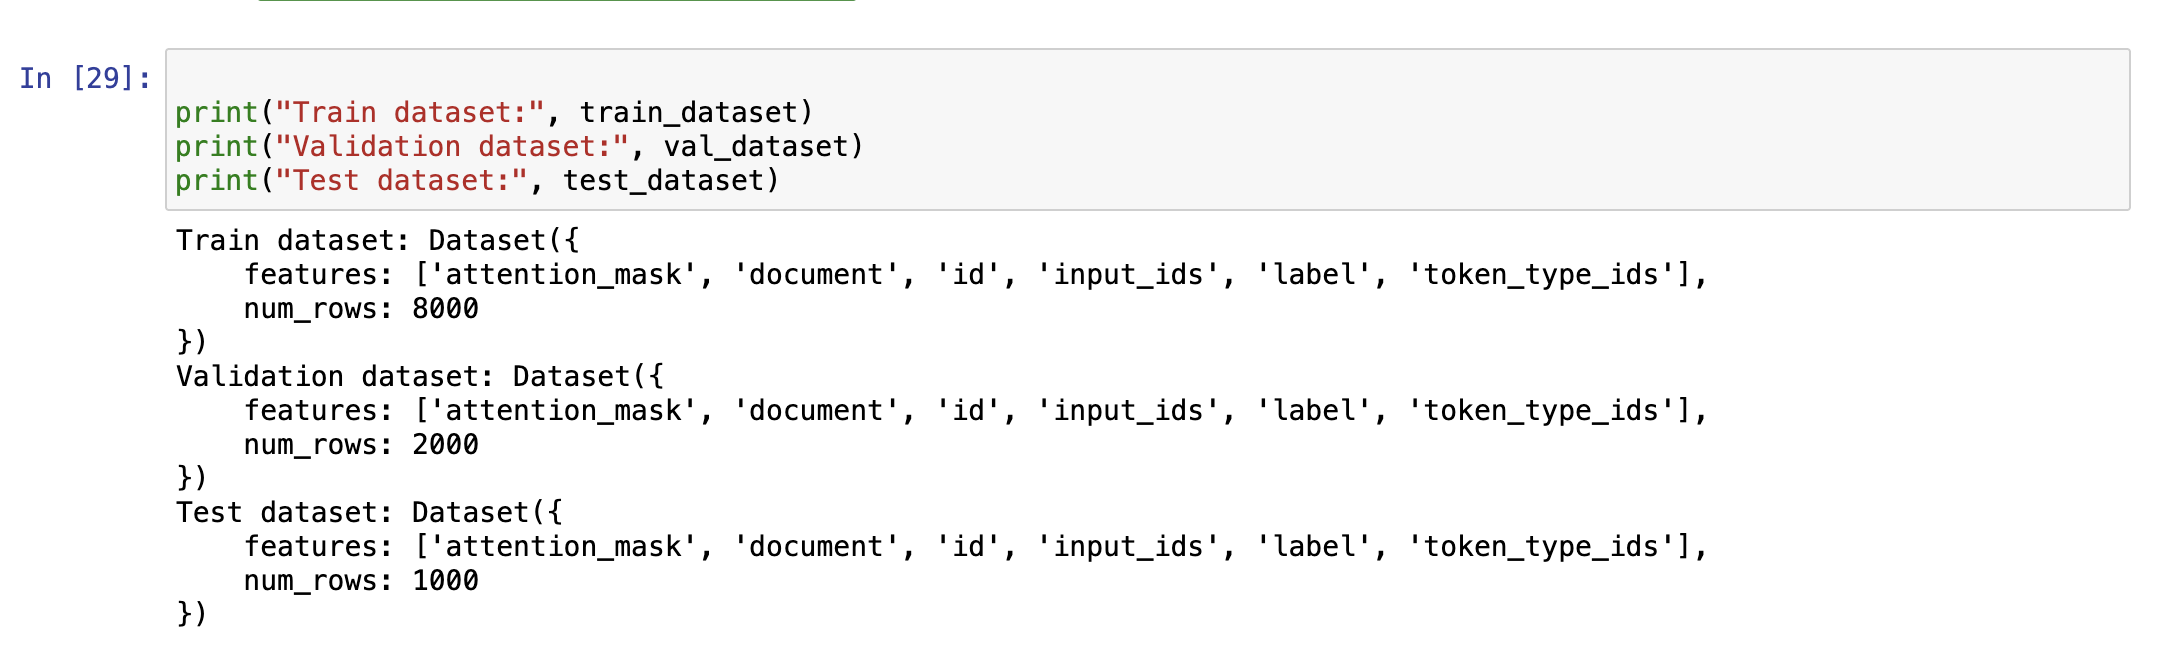

### Bucketing 적용

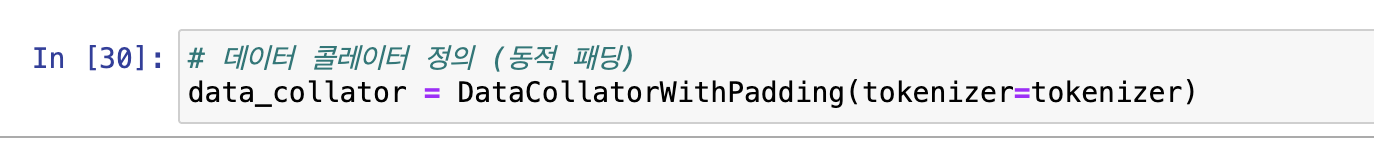

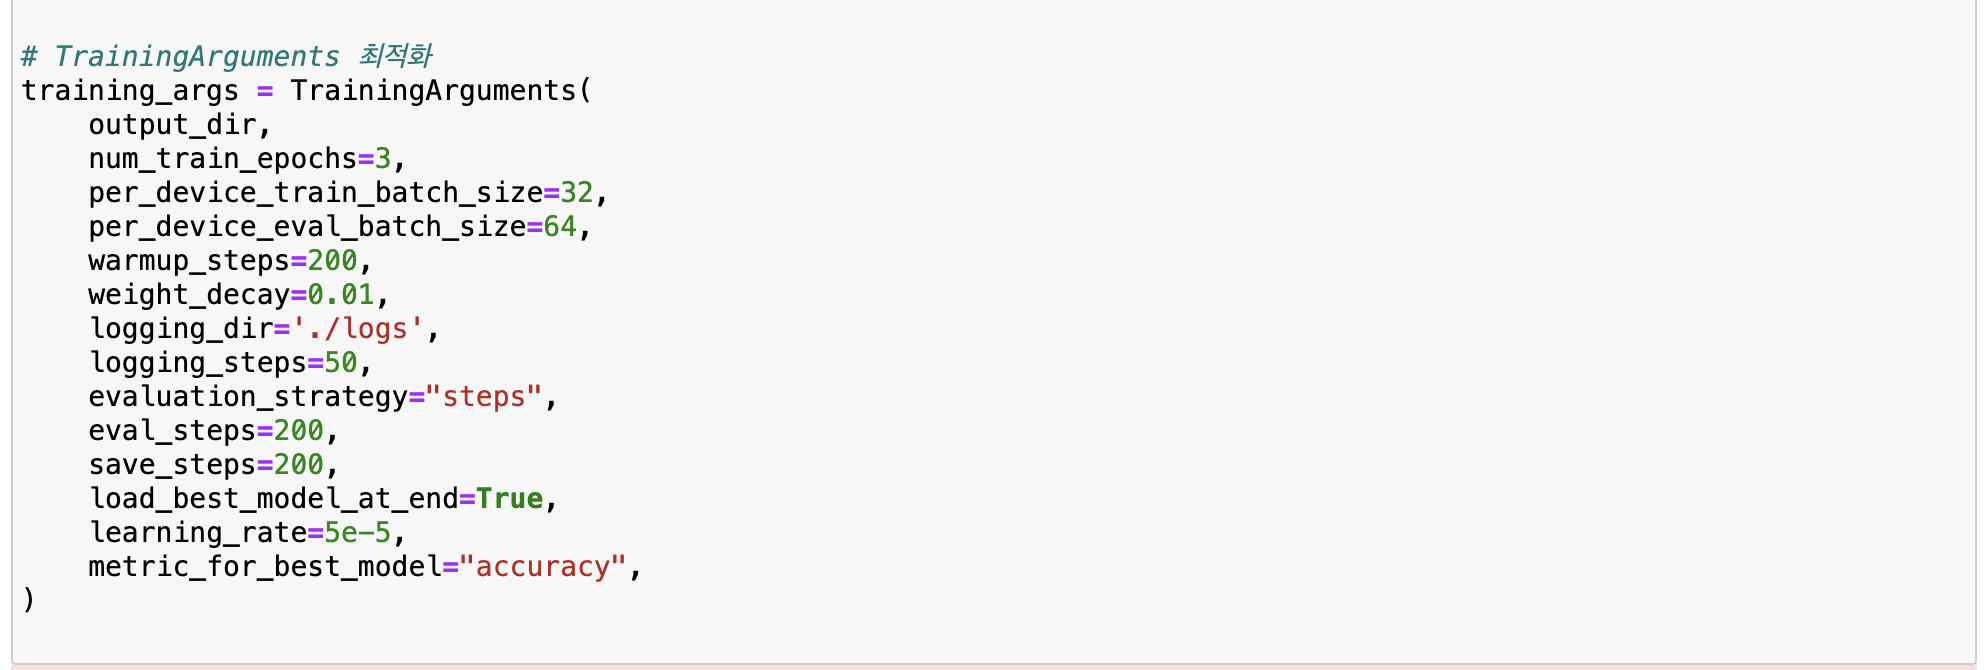

### 결과
**Bucketing을 적용하여 학습시키니 학습시간이 크게 감소했습니다. 정확도는 큰 차이 없습니다!**

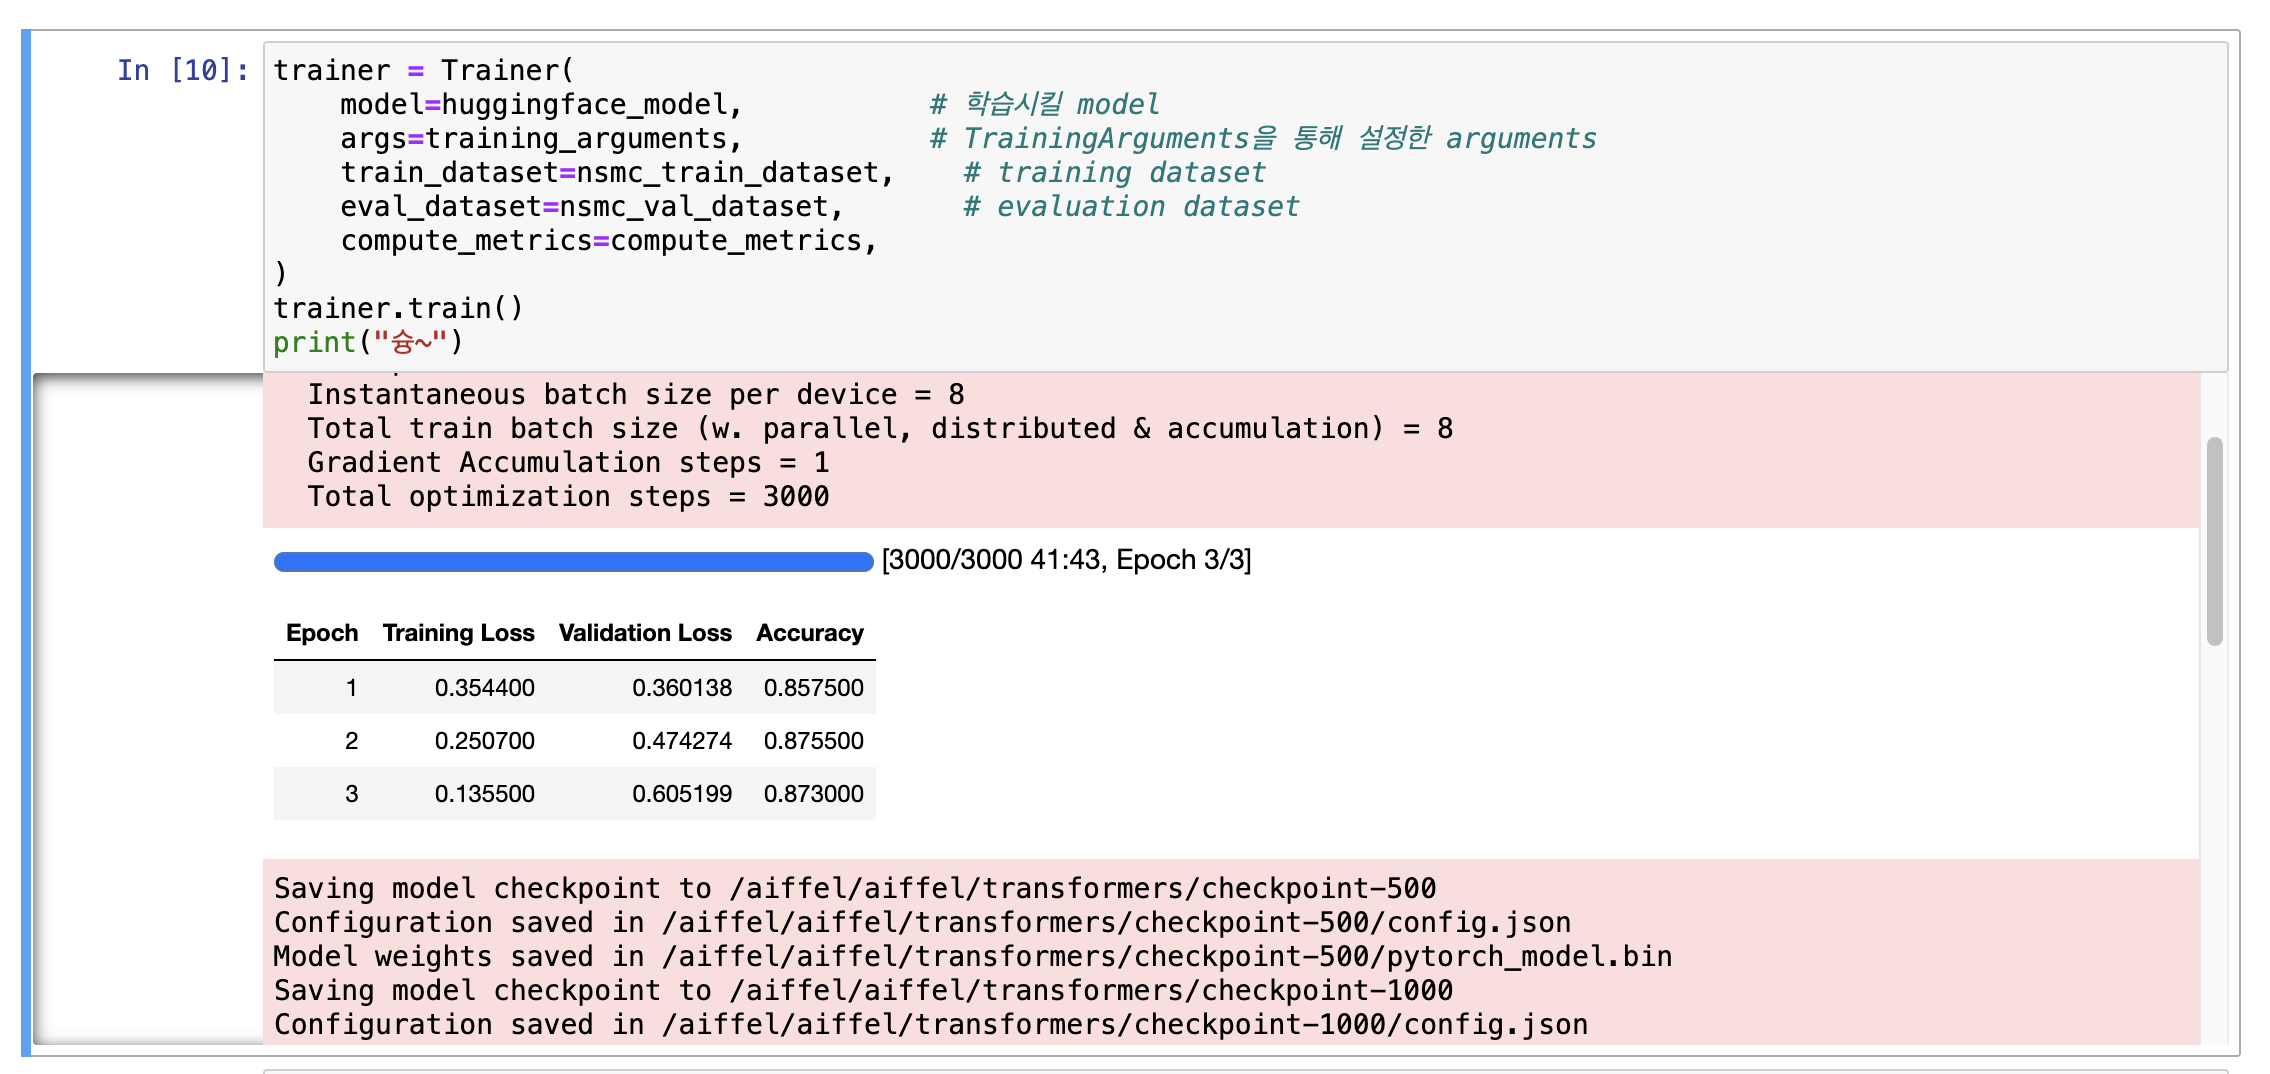

**학습시간: 40분 / 정확도: 0.87**

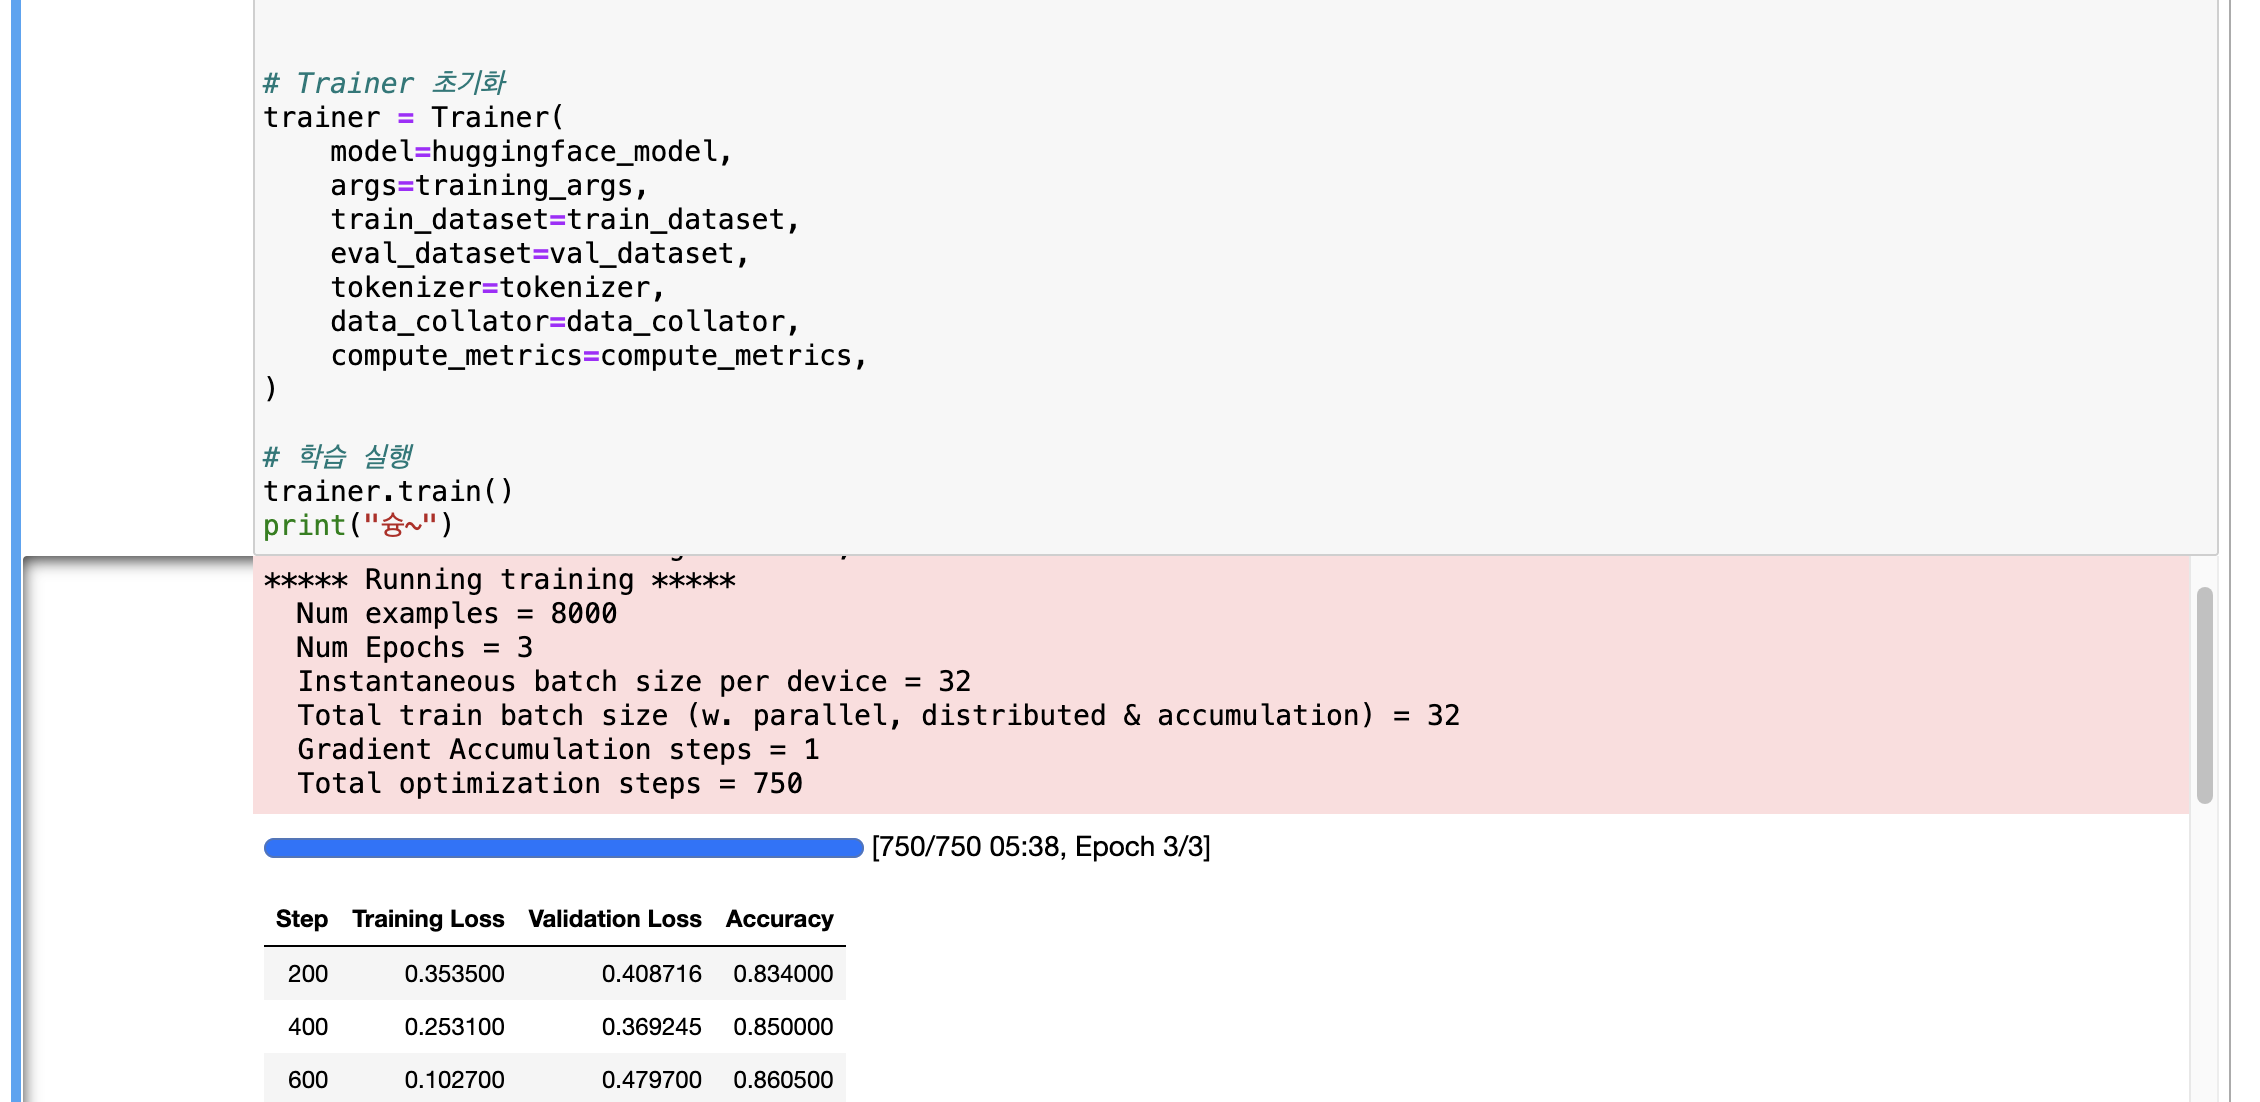

**학습시간: 5분 / 정확도: 0.86**

+) 파인튜닝은,,, 배치사이즈가 전혀 바뀌지 않아서 큰 의미가 없었습니다,,

**두번째 시도 = 전체 데이터셋 중 100,000개 사용**

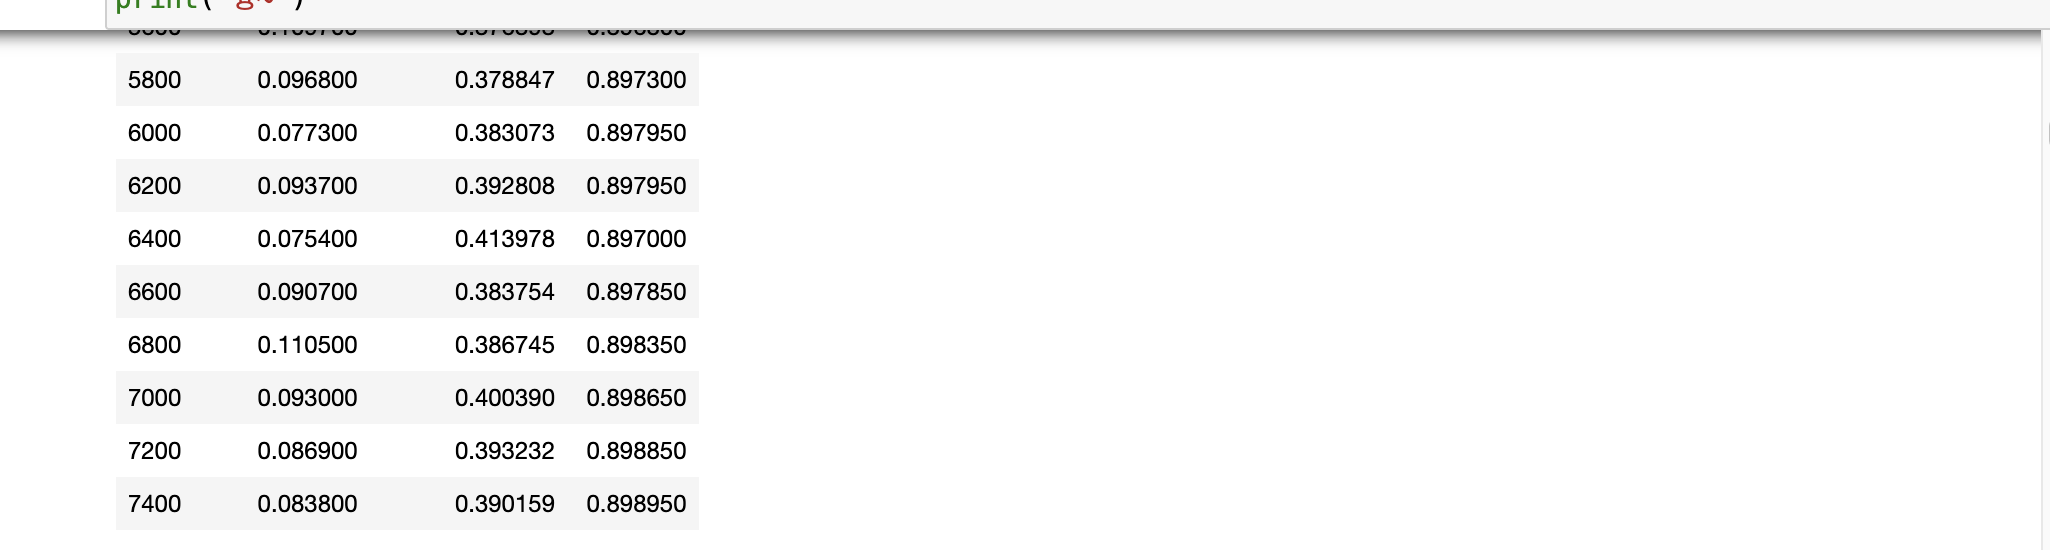

2시간이니 걸렸는데 ,, !!!! 0.89,,,

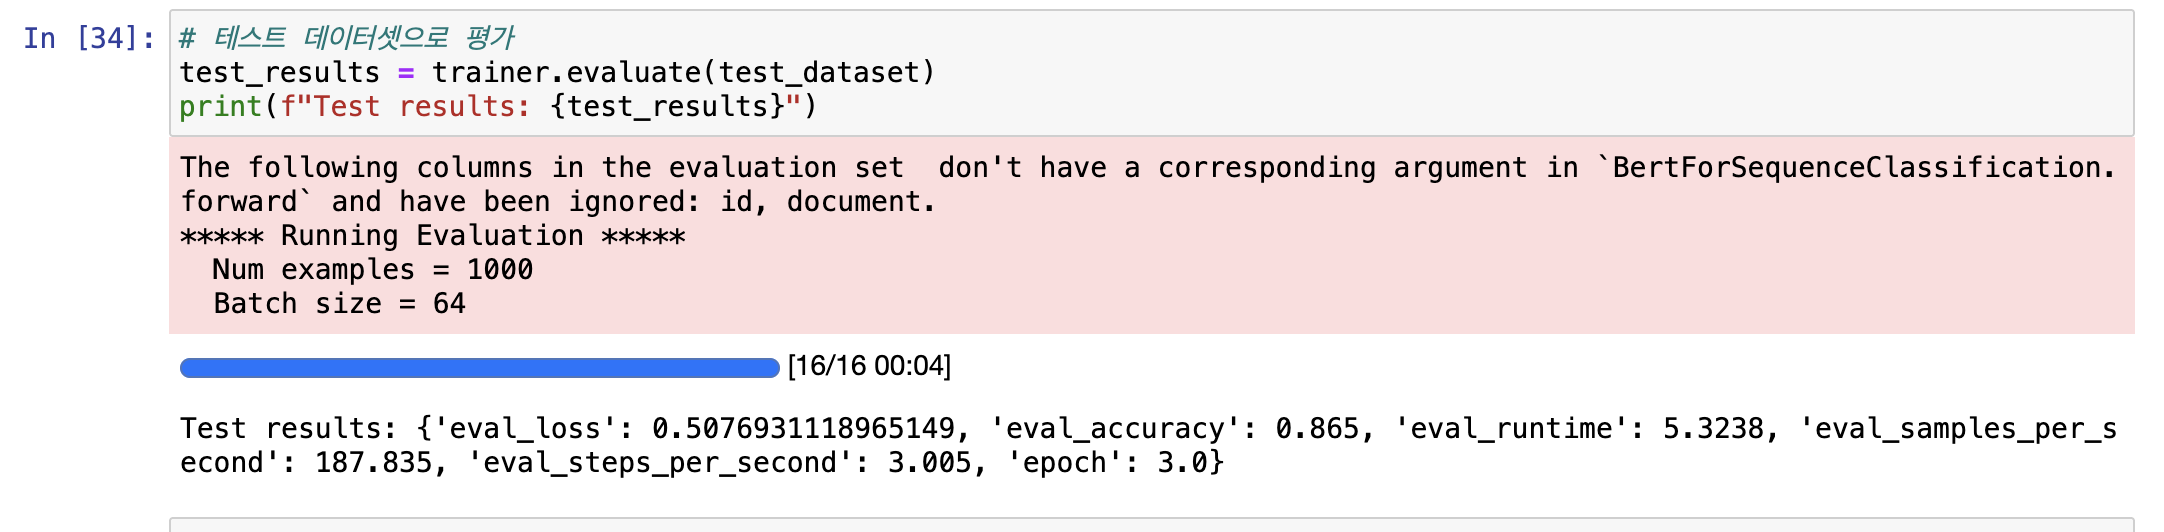

그런데 알고보니 group_by_length 설정을 안했다,, 급히 설정하려고 했는데 오류가 너무 많이 나서 던졌습니다,, 수정 예정,,